In [63]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd 
import torch
from sentence_transformers import models, losses, evaluation, SentenceTransformer
import os
import json
from transformers import BertJapaneseTokenizer, BertModel
import pickle

from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold


from sklearn.preprocessing import StandardScaler

from modules import meishi,wakachi
import mojimoji

In [65]:
from modules import one_hot, ShowList,makeAug, diago, sBERT_model,use_sBERT_model
from modules import label_encording, Add_class_wight,run_LGBM, make_nn_model
from modules import use_fasttext_model, make_results, model_evaluation, FI_LGBM, kfold_report
from modules import tokens, tokens2, preprosess

In [4]:
#分かち書き等の前処理
df_train = preprosess('../CSVs/AugumentaitionData_train.csv')
pre = preprosess('../CSVs/CorrectedData_train.csv')
df_test = preprosess('../CSVs/CorrectedData_test.csv')
print(len(df_train),len(df_test),len(pre))

df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

df=df.drop(['男','造影',], axis=1)

print(len(df))

19532 3655 19276
23187


df = tokens(df)

df = tokens2(df)

#分かち書き後のdf
#
with open ('../PICKLES/df.pkl', 'wb') as f:
    pickle.dump(df, f)

with open ('../PICKLES/df.pkl', 'rb') as f:
    df = pickle.load(f)

### 平均単語数の確認(学習データ)

In [27]:
with open ('../PICKLES/df.pkl', 'rb') as f:
    df = pickle.load(f)
df_train = df[:19532].reset_index(drop=True)
df_test = df[19532:].reset_index(drop=True)
print(len(df_train))
print(len(df_test))

19532
3655


In [242]:
label = df_train['label']
diago_num = df_train['new_diagnosis'].map(len)
meishi_num = df_train['ft_purpose'].map(len)
token_num =  df_train['sB_purpose'].map(len)

num_df = pd.DataFrame(list(zip(label,diago_num, meishi_num,token_num)), columns = ['label','diago','p_meishi','p_token'])
a=num_df.groupby('label').mean().reset_index()
a=a.replace(dic).rename(columns={'label': 'index'})
a
#print(num_df.groupby('label').max())
#print(num_df.groupby('label').min())

,index,diago,p_meishi,p_token
0,lower extremity artery,3,10,46
1,general abodomen,3,19,78
2,ovary,1,13,60
3,uterus,1,13,59
4,fetus/placenta,3,16,75
5,intestinal tract,3,13,55
6,Bone and soft tissue tumor,2,12,57
7,Bone and soft tissue tumor(joint),2,12,53
8,bladder,1,10,43
9,mediastinum,1,11,47


### diagnosisのみvev(ft)変形

In [16]:
# df = diago(df)

In [17]:
#diagoの変換後のdf


# with open ('../PICKLES/df_dia.pkl', 'wb') as f:
#     pickle.dump(df, f)

# with open ('../PICKLES/df_dia.pkl', 'rb') as f:
#     df = pickle.load(f)

In [19]:
len(df)

23187

### purpose（文書）の変形 
### １sentenceBERT

In [35]:
with open ('../PICKLES/df_dia.pkl', 'rb') as f:
    df = pickle.load(f)

In [7]:
smodel = sBERT_model("../data/model/strf_sonoisa_sentence-bert-base-ja-mean-tokens-v232.75.10")
output = '../CSVs/sBERT_traindata.csv'

In [8]:
smodel

SentenceTransformer(
  (0): Transformer({'max_seq_length': 75, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (dense): Dense({'in_features': 768, 'out_features': 139, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
)

In [13]:
df = use_sBERT_model(df ,'sB_purpose', smodel, output)

In [4]:
###作成後読み取り

df_sBERT=pd.read_csv("../CSVs/sBERT_traindata.csv")

df_sBERT=df_sBERT.drop([ 'Unnamed: 0', 'purpose', 'diagnosis','new_diagnosis','ft_purpose','sB_purpose' ], axis=1)

In [5]:
df_sBERT.head()

,year,section,label,position,女,単純,Dvec0,Dvec1,Dvec2,Dvec3,...,P(S)vec129,P(S)vec130,P(S)vec131,P(S)vec132,P(S)vec133,P(S)vec134,P(S)vec135,P(S)vec136,P(S)vec137,P(S)vec138
0,37,形外,A2,下腿部,1,1,0.1450,0.10114,0.1677,-0.4750,...,0.560565,0.350004,0.018902,0.140595,-0.163510,-0.037759,-0.151352,1.322811,-0.465725,0.406783
1,0,小児,AB1,腰椎(髄),1,1,0.1292,-0.05978,0.3804,-0.2783,...,-0.012278,-0.006605,-0.149853,-0.123465,-0.217480,-0.006561,0.364466,0.303277,-0.279168,-0.623212
2,0,小児,AB1,上腹部(肝胆膵他）,1,0,0.3687,-0.50150,0.9067,-0.7827,...,-0.256892,0.068749,-0.447604,-0.064568,0.522742,0.268994,0.447376,-0.421408,0.261408,0.512235
3,0,小児,AB4,泌尿器系下腹部,0,1,0.3352,0.07830,0.2245,-0.0503,...,0.296871,0.097009,0.383809,-0.663290,-0.161524,0.694160,0.212134,0.892348,-0.577844,-0.145556
4,0,小児,B1,肩軟部,1,1,-0.2580,-0.23230,1.2350,-0.7856,...,-0.231875,0.003006,-0.010565,-0.249378,-0.014923,-0.300648,-0.154086,0.368285,-0.253333,0.202860


### purpose（文書）の変形 
### 2fasttext

In [20]:
with open ('../PICKLES/df_dia.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:

fmodel = "../data/model/fasttext_meishi_model.bin"

output = '../CSVs/ft_traindata.csv'

df = use_fasttext_model(df,'ft_purpose', fmodel, output)

In [28]:
###作成後読み取り

df_ft=pd.read_csv("../CSVs/ft_traindata.csv")

df_ft=df_ft.drop(['Unnamed: 0', 'purpose', 'diagnosis','new_diagnosis','ft_purpose','sB_purpose'], axis=1)

In [29]:
df_ft.head()

,year,section,label,position,女,単純,Dvec0,Dvec1,Dvec2,Dvec3,Dvec4,Dvec5,Dvec6,Dvec7,Dvec8,Dvec9,Dvec10,Dvec11,Dvec12,Dvec13,Dvec14,Dvec15,Dvec16,Dvec17,Dvec18,Dvec19,Dvec20,Dvec21,Dvec22,Dvec23,Dvec24,Dvec25,Dvec26,Dvec27,Dvec28,Dvec29,Dvec30,Dvec31,Dvec32,Dvec33,Dvec34,Dvec35,Dvec36,Dvec37,Dvec38,Dvec39,Dvec40,Dvec41,Dvec42,Dvec43,Dvec44,Dvec45,Dvec46,Dvec47,Dvec48,Dvec49,Dvec50,Dvec51,Dvec52,Dvec53,Dvec54,Dvec55,Dvec56,Dvec57,Dvec58,Dvec59,Dvec60,Dvec61,Dvec62,Dvec63,Dvec64,Dvec65,Dvec66,Dvec67,Dvec68,Dvec69,Dvec70,Dvec71,Dvec72,Dvec73,Dvec74,Dvec75,Dvec76,Dvec77,Dvec78,Dvec79,Dvec80,Dvec81,Dvec82,Dvec83,Dvec84,Dvec85,Dvec86,Dvec87,Dvec88,Dvec89,Dvec90,Dvec91,Dvec92,Dvec93,Dvec94,Dvec95,Dvec96,Dvec97,Dvec98,Dvec99,P(f)vec0,P(f)vec1,P(f)vec2,P(f)vec3,P(f)vec4,P(f)vec5,P(f)vec6,P(f)vec7,P(f)vec8,P(f)vec9,P(f)vec10,P(f)vec11,P(f)vec12,P(f)vec13,P(f)vec14,P(f)vec15,P(f)vec16,P(f)vec17,P(f)vec18,P(f)vec19,P(f)vec20,P(f)vec21,P(f)vec22,P(f)vec23,P(f)vec24,P(f)vec25,P(f)vec26,P(f)vec27,P(f)vec28,P(f)vec29,P(f)vec30,P(f)vec31,P(f)vec32,P(f)vec33,P(f)vec34,P(f)vec35,P(f)vec36,P(f)vec37,P(f)vec38,P(f)vec39,P(f)vec40,P(f)vec41,P(f)vec42,P(f)vec43,P(f)vec44,P(f)vec45,P(f)vec46,P(f)vec47,P(f)vec48,P(f)vec49,P(f)vec50,P(f)vec51,P(f)vec52,P(f)vec53,P(f)vec54,P(f)vec55,P(f)vec56,P(f)vec57,P(f)vec58,P(f)vec59,P(f)vec60,P(f)vec61,P(f)vec62,P(f)vec63,P(f)vec64,P(f)vec65,P(f)vec66,P(f)vec67,P(f)vec68,P(f)vec69,P(f)vec70,P(f)vec71,P(f)vec72,P(f)vec73,P(f)vec74,P(f)vec75,P(f)vec76,P(f)vec77,P(f)vec78,P(f)vec79,P(f)vec80,P(f)vec81,P(f)vec82,P(f)vec83,P(f)vec84,P(f)vec85,P(f)vec86,P(f)vec87,P(f)vec88,P(f)vec89,P(f)vec90,P(f)vec91,P(f)vec92,P(f)vec93,P(f)vec94,P(f)vec95,P(f)vec96,P(f)vec97,P(f)vec98,P(f)vec99,P(f)vec100,P(f)vec101,P(f)vec102,P(f)vec103,P(f)vec104,P(f)vec105,P(f)vec106,P(f)vec107,P(f)vec108,P(f)vec109,P(f)vec110,P(f)vec111,P(f)vec112,P(f)vec113,P(f)vec114,P(f)vec115,P(f)vec116,P(f)vec117,P(f)vec118,P(f)vec119,P(f)vec120,P(f)vec121,P(f)vec122,P(f)vec123,P(f)vec124,P(f)vec125,P(f)vec126,P(f)vec127,P(f)vec128,P(f)vec129,P(f)vec130,P(f)vec131,P(f)vec132,P(f)vec133,P(f)vec134,P(f)vec135,P(f)vec136,P(f)vec137,P(f)vec138,P(f)vec139,P(f)vec140,P(f)vec141,P(f)vec142,P(f)vec143,P(f)vec144,P(f)vec145,P(f)vec146,P(f)vec147,P(f)vec148,P(f)vec149,P(f)vec150,P(f)vec151,P(f)vec152,P(f)vec153,P(f)vec154,P(f)vec155,P(f)vec156,P(f)vec157,P(f)vec158,P(f)vec159,P(f)vec160,P(f)vec161,P(f)vec162,P(f)vec163,P(f)vec164,P(f)vec165,P(f)vec166,P(f)vec167,P(f)vec168,P(f)vec169,P(f)vec170,P(f)vec171,P(f)vec172,P(f)vec173,P(f)vec174,P(f)vec175,P(f)vec176,P(f)vec177,P(f)vec178,P(f)vec179,P(f)vec180,P(f)vec181,P(f)vec182,P(f)vec183,P(f)vec184,P(f)vec185,P(f)vec186,P(f)vec187,P(f)vec188,P(f)vec189,P(f)vec190,P(f)vec191,P(f)vec192,P(f)vec193,P(f)vec194,P(f)vec195,P(f)vec196,P(f)vec197,P(f)vec198,P(f)vec199,P(f)vec200,P(f)vec201,P(f)vec202,P(f)vec203,P(f)vec204,P(f)vec205,P(f)vec206,P(f)vec207,P(f)vec208,P(f)vec209,P(f)vec210,P(f)vec211,P(f)vec212,P(f)vec213,P(f)vec214,P(f)vec215,P(f)vec216,P(f)vec217,P(f)vec218,P(f)vec219,P(f)vec220,P(f)vec221,P(f)vec222,P(f)vec223,P(f)vec224,P(f)vec225,P(f)vec226,P(f)vec227,P(f)vec228,P(f)vec229,P(f)vec230,P(f)vec231,P(f)vec232,P(f)vec233,P(f)vec234,P(f)vec235,P(f)vec236,P(f)vec237,P(f)vec238,P(f)vec239,P(f)vec240,P(f)vec241,P(f)vec242,P(f)vec243,P(f)vec244,P(f)vec245,P(f)vec246,P(f)vec247,P(f)vec248,P(f)vec249,P(f)vec250,P(f)vec251,P(f)vec252,P(f)vec253,P(f)vec254,P(f)vec255,P(f)vec256,P(f)vec257,P(f)vec258,P(f)vec259,P(f)vec260,P(f)vec261,P(f)vec262,P(f)vec263,P(f)vec264,P(f)vec265,P(f)vec266,P(f)vec267,P(f)vec268,P(f)vec269,P(f)vec270,P(f)vec271,P(f)vec272,P(f)vec273,P(f)vec274,P(f)vec275,P(f)vec276,P(f)vec277,P(f)vec278,P(f)vec279,P(f)vec280,P(f)vec281,P(f)vec282,P(f)vec283,P(f)vec284,P(f)vec285,P(f)vec286,P(f)vec287,P(f)vec288,P(f)vec289,P(f)vec290,P(f)vec291,P(f)vec292,P(f)vec293,P(f)vec294,P(f)vec295,P(f)vec296,P(f)vec297,P(f)vec298,P(f)vec299
0,37,形外,A2,下腿部,1,1,0.1450,0.10114,0.1677,-0.4750,-0.10730,-0.21960,-0.25270,-0.16370,0

### データ選択と変形

In [30]:
#####################################


df = df_ft
#df = df_sBERT


########################################

In [31]:
# カテゴリカルデータをラベルエンコード
from sklearn import preprocessing
lbl_s = preprocessing.LabelEncoder()
lbl_s.fit(df['section'])
lbl_section = lbl_s.transform(df['section'])

lbl_p = preprocessing.LabelEncoder()
lbl_p.fit(df['position'])
lbl_position = lbl_p.transform(df['position'])

lbl_l = preprocessing.LabelEncoder()
lbl_l.fit(df['label'])
lbl_label = lbl_l.transform(df['label'])




y = lbl_label
X = df.drop(['label', 'section', 'position'], axis=1)
X['sec_lbl'] = lbl_section
X['pos_lbl'] = lbl_position
#X['label_lbl'] = lbl_label


print(len(X), len(y))

23187 23187


In [26]:
#学習データとテストデータに分ける
X_train = X.iloc[:19532]
X_test = X.iloc[19532:]

y_train = y[:19532]
y_test = y[19532:]

In [27]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

19532 19532
3655 3655


### 学習

### Kfold_LBGM
#https://an-engineer-note.com/?p=312

In [17]:
# 5-fold CVモデルの学習
# 5つのモデルを保存するリストの初期化
models = []

train_results = [] #学習の経過を保存する箱のまとめ

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=4, shuffle=True,  random_state=0)

categorical_features = {*sorted(['pos_lbl', 'sec_lbl'])}

In [18]:
# KFoldクラスで分割した回数だけ実行（ここでは4回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    #不均衡データの重み
    w_array=Add_class_wight(X_train_cv,  y_train_cv) 
    
    model, result = run_LGBM(X_train_cv, y_train_cv,X_eval_cv, y_eval_cv ,CF=categorical_features, CW=w_array)
    
    models.append(model)
    train_results.append(result)

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and w

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102117
[LightGBM] [Info] Number of data points in the train set: 14649, number of used features: 405


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score -3.989146
[LightGBM] [Info] Start training from score -3.989189
[LightGBM] [Info] Start training from score -3.989044
[LightGBM] [Info] Start training from score -3.988822
[LightGBM] [Info] Start training from score -3.988714
[LightGBM] [Info] Start training from score -3.988729
[LightGBM] [Info] Start training from score -3.989211
[LightGBM] [Info] Start training from score -3.988952
[LightGBM] [Info] Start training from score -3.988822
[LightGBM] [Info] Start training from score -3.988873
[LightGBM] [Info] Start training from score -3.988873
[LightGBM] [Info] Start training from score -3.988952
[LightGBM] [Info] Start training from score -3.988777
[LightGBM] [Info] Start training from score -3.988700
[LightGBM] [Info] Start training from score -3.989146
[LightGBM] [Info] Start training from score -3.989276
[LightGBM] [Info] Start training from score -3.988945
[LightGBM] [Info] Start training from score -3.988930
[LightGBM] [Info] Start trai

### modelsのsave

In [22]:
#fasttext

# with open ('../PICKLES/ftlGBMmodel.pkl', 'wb') as f:
#     pickle.dump(models, f)

In [88]:
#sBERT 

# with open ('../PICKLES/sBlGBMmodel.pkl', 'wb') as f:
#     pickle.dump(models, f)

### LGBM結果のモデル選択

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

accuracy        0.839330
macro avg       0.753563
weighted avg    0.844416
dtype: float64


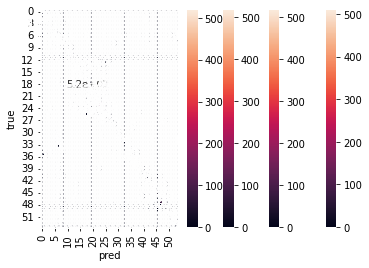

In [29]:
#fasttext LGBM
with open ('../PICKLES/ftLGBMmodel.pkl', 'rb') as f:
    ft_LGBM_models = pickle.load(f)

ft_LGBM_results, ft_LGBM_reports = model_evaluation(ft_LGBM_models, X_test, y_test, method='LGBM')
with open ('../PICKLES/ft_LGBM_results.pkl', 'wb') as f:
    pickle.dump(ft_LGBM_results, f)
    
report=kfold_report(ft_LGBM_reports, 'ft_LGBM_report')
print(report)

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

accuracy        0.842818
macro avg       0.768693
weighted avg    0.847760
dtype: float64


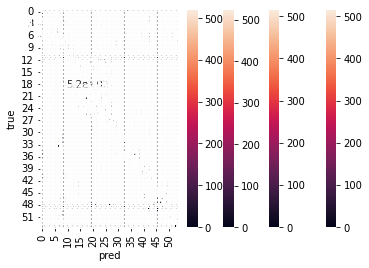

In [42]:
#sBERT LGBM
with open ('../PICKLES/sBLGBMmodel.pkl', 'rb') as f:
    sB_LGBM_models = pickle.load(f)

sB_LGBM_results, sB_LGBM_reports = model_evaluation(sB_LGBM_models, X_test, y_test, method='LGBM')
with open ('../PICKLES/sB_LGBM_results.pkl', 'wb') as f:
    pickle.dump(sB_LGBM_results, f)
    
report=kfold_report(sB_LGBM_reports, 'sB_LGBM_report')
print(report)

### FIの比較

In [23]:
with open ('../PICKLES/ftLGBMmodel.pkl', 'rb') as f:
    ft_LGBM_models = pickle.load(f)
    
with open ('../PICKLES/sBLGBMmodel.pkl', 'rb') as f:
    sB_LGBM_models = pickle.load(f)

Is = FI_LGBM(ft_LGBM_models, X_test)
Is[3][:10]

,importance
pos_lbl,328997.784928
year,29668.559396
Dvec30,23255.156584
Dvec25,22733.718679
sec_lbl,21272.369200
Dvec40,21136.341361
Dvec12,19880.455474
Dvec64,15308.444966
Dvec88,15205.269439
Dvec57,15058.750860


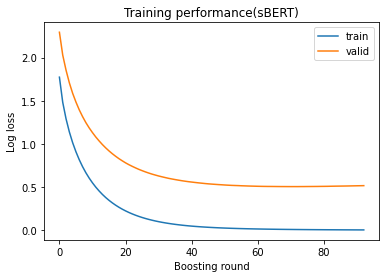

In [24]:
# 学習過程の可視化
plt.plot(train_results[0]['train']['multi_logloss'], label='train')
plt.plot(train_results[0]['valid']['multi_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance(sBERT)')
plt.legend()
plt.show()

#https://potesara-tips.com/lightgbm-holdout/
#https://potesara-tips.com/lightgbm-k-fold-cross-validation/

### NN(keras) 4fold

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=ja

In [43]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Input
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [44]:
#注意: StandardScalerはtrain_featuresを使用する場合にのみ適合し、モデルが検証セットやテストセットでピークを迎えることがないようにします。
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

X_train_ss = np.clip(X_train_ss, -5, 5)
X_test_ss = np.clip(X_test_ss, -5, 5)

### nn学習

In [27]:
#https://github.com/ghmagazine/kagglebook/blob/master/ch03/ch03-02-categorical.py
# target encoding - クロスバリデーションのfoldごとの場合
# クロスバリデーションのfoldごとにtarget encodingをやり直す
nn_models= []

histories = []
# 変換するカテゴリ変数をリストに格納
cat_cols = ['pos_lbl', 'sec_lbl']

class_num = 54

row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=4, shuffle=True,  random_state=0)




for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = pd.DataFrame(X_train_ss, columns=X_train.columns).iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = pd.DataFrame(X_train_ss, columns=X_train.columns).iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    
    w_array=Add_class_wight(X_train_cv,  y_train_cv)   
    print(len(w_array), len(X_train_cv))
    

    
    # 変数をループしてtarget encoding
    for c in cat_cols:
        # 学習データ全体で各カテゴリにおけるtargetの平均を計算
        data_tmp = pd.DataFrame({c: X_train_cv[c], 'target': y_train_cv})
        target_mean = data_tmp.groupby(c)['target'].mean()
        # バリデーションデータのカテゴリを置換
        X_eval_cv.loc[:, c] = X_eval_cv[c].map(target_mean)
        
        
        # 学習データの変換後の値を格納する配列を準備
        tmp = np.repeat(np.nan, X_train_cv.shape[0])
        
        # 学習データを分割(target encording)
        kf = KFold(n_splits=4, shuffle=True, random_state=0)
        
        kf_encoding = KFold(n_splits=4, shuffle=True, random_state=0)
        for idx_1, idx_2 in kf_encoding.split(X_train_cv):
            # out-of-foldで各カテゴリにおける目的変数の平均を計算
            target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
            # 変換後の値を一時配列に格納
            tmp[idx_2] = X_train_cv[c].iloc[idx_2].map(target_mean)

        X_train_cv.loc[:, c] = tmp
        
    
    model = make_nn_model(X_train, class_num)     

    early_stopping = tf.keras.callbacks.EarlyStopping( 
        verbose=1,
        patience=10,
        mode='auto',
        restore_best_weights=True)
    
    EPOCHS = 50
    BATCH_SIZE = 128
    
    history = model.fit(
        X_train_cv,
        y_train_cv,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(X_eval_cv, y_eval_cv),
        #class_weight=w_array
    )
    
    y_eval_pred = model.predict(X_eval_cv)
    histories.append(history)
    nn_models.append(model) 
    #pd.DataFrame(history.history).plot(figsize=(8,5))    

14649 14649


2022-12-06 18:09:58.481664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-06 18:09:58.485066: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 18:09:58.486109: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3ed327de65ae): /proc/driver/nvidia/version does not exist
2022-12-06 18:09:58.494846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
115/115 [==============================] - 3s 16ms/step - loss: 1.0218 - accuracy: 0.7117 - val_loss: 1.5066 - val_accuracy: 0.6502
Epoch 2/50
115/115 [==============================] - 2s 14ms/step - loss: 0.6642 - accuracy: 0.7919 - val_loss: 0.7334 - val_accuracy: 0.7899
Epoch 3/50
115/115 [==============================] - 1s 13ms/step - loss: 0.5948 - accuracy: 0.8147 - val_loss: 0.7074 - val_accuracy: 0.7968
Epoch 4/50
115/115 [==============================] - 2s 14ms/step - loss: 0.5380 - accuracy: 0.8285 - val_loss: 0.6351 - val_accuracy: 0.8118
Epoch 5/50
115/115 [==============================] - 1s 13ms/step - loss: 0.5141 - accuracy: 0.8344 - val_loss: 0.5686 - val_accuracy: 0.8341
Epoch 6/50
115/115 [==============================] - 1s 13ms/step - loss: 0.4780 - accuracy: 0.8456 - val_loss: 0.5410 - val_accuracy: 0.8386
Epoch 7/50
115/115 [==============================] - 1s 12ms/step - loss: 0.4528 - accuracy: 0.8541 - val_loss: 0.5806 - val_accuracy: 0.8325

### modelのsave

In [28]:
#fasttext

# with open ('../PICKLES/ftNNmodel.pkl', 'wb') as f:
#     pickle.dump(nn_models, f)

INFO:tensorflow:Assets written to: ram://1e1959d7-4951-403b-90fb-7465cb8df587/assets
INFO:tensorflow:Assets written to: ram://0c3d8c0b-f942-46b6-b43e-f155a9e28ef1/assets
INFO:tensorflow:Assets written to: ram://ceed22e6-b1cb-4ce2-8ae7-a5755ff20299/assets
INFO:tensorflow:Assets written to: ram://235c7b53-fdaf-4587-bc0e-cae3e9b0eebe/assets


In [ ]:
#sBERT 

# with open ('../PICKLES/sBNNmodel.pkl', 'wb') as f:
#     pickle.dump(nn_models, f)

### NN 結果表示のモデル選択

In [45]:
#テスト時は学習データ全ての平均をテストデータの各ラベルに置き換える。
#cat変数の変更

cat_cols = ['pos_lbl', 'sec_lbl']

X_test = pd.DataFrame(X_test_ss, columns=X_test.columns)
y_test = pd.Series(y_test)
X_train = pd.DataFrame(X_train_ss, columns=X_train.columns)
y_train = pd.Series(y_train)
    

for c in cat_cols:
        # 学習データ全体で各カテゴリにおけるtargetの平均を計算
        data_tmp = pd.DataFrame({c: X_train[c], 'target': y_train})
        target_mean = data_tmp.groupby(c)['target'].mean()
        
        X_test.loc[:, c] = X_test[c].map(target_mean)        

115/115 [==============================] - 1s 3ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115/115 [==============================] - 1s 4ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115/115 [==============================] - 1s 4ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115/115 [==============================] - 1s 4ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy        0.826744
macro avg       0.733253
weighted avg    0.833096
dtype: float64


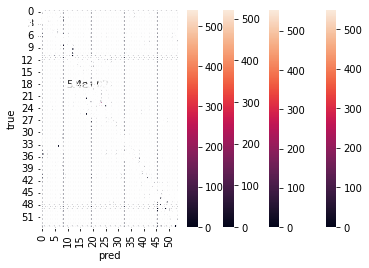

In [33]:
#fasttext nn
with open ('../PICKLES/ftNNmodel.pkl', 'rb') as f:
    ft_NN_models = pickle.load(f)
    
ft_nn_results, ft_nn_reports = model_evaluation(ft_NN_models, X_test, y_test, method='NN')
with open ('../PICKLES/ft_nn_results.pkl', 'wb') as f:
    pickle.dump(ft_nn_results, f)
    
report=kfold_report(ft_nn_reports, 'ft_nn_report')
print(report)

115/115 [==============================] - 0s 3ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115/115 [==============================] - 1s 4ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115/115 [==============================] - 1s 5ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy        0.819289
macro avg       0.729238
weighted avg    0.825468
dtype: float64


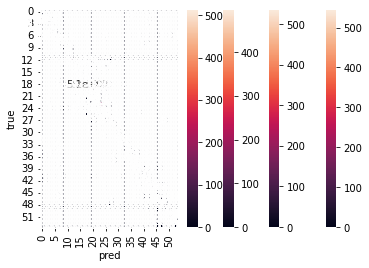

In [46]:
#sBERT nn
with open ('../PICKLES/sBNNmodel.pkl', 'rb') as f:
    sB_NN_models = pickle.load(f)

sB_nn_results, sB_nn_reports = model_evaluation(sB_NN_models, X_test, y_test, method='NN')
with open ('../PICKLES/sB_nn_results.pkl', 'wb') as f:
    pickle.dump(sB_nn_results, f)

report=kfold_report(sB_nn_reports, 'sB_nn_report')
print(report)

###　データごとのラベル数

In [210]:
labels = np.unique(lbl_l.inverse_transform(y))
new_labels = ['lower extremity artery','general abodomen','ovary','uterus','fetus/placenta',
           'intestinal tract','Bone and soft tissue tumor', 'Bone and soft tissue tumor(joint)','bladder', 'mediastinum',
           'heart', 'breast', 'head/neck artery', 'maltiple sclerosis','brainstem' ,
           'epilepsy','jaw','orbital tumor', 'general brain',
           'optinc nerve', 'newborn brain', 'carotid plaque/artery dissection', 'pituitaly gland', 'brian metastasis',
           'brain tumor/encephalitis', 'vestibulocochlear', 'dementia','head/spine(newborn)', 'kidney/adrenal glad','abdominal vessels',
            'hip joint',
            'knee', 'Myositis', 'ankle joint', 'toes', 'upper abdomen',
            'MRCP', 'liver', 'head and neck(soft tissue)', 'prostate', 'hernia',
            'lower abdomen', 'rectum', 'cervical spine', 'brachial plexus', 'thoracic spine',
             'lumbar spine','whole spine', 'Spinal cord lesion', 'Sacral spine pelvis', 'shoulder',
              'wrist',
             'finger', 'elbow']

dic = {key: val for key, val in zip(labels, new_labels)}

In [211]:
print(dic)

{'A2': 'lower extremity artery', 'AB1': 'general abodomen', 'AB3': 'ovary', 'AB4': 'uterus', 'AB5': 'fetus/placenta', 'AB6': 'intestinal tract', 'B1': 'Bone and soft tissue tumor', 'B2': 'Bone and soft tissue tumor(joint)', 'BL1': 'bladder', 'C1': 'mediastinum', 'C2': 'heart', 'C3': 'breast', 'H1': 'head/neck artery', 'H12': 'maltiple sclerosis', 'H13': 'brainstem', 'H15': 'epilepsy', 'H17': 'jaw', 'H18': 'orbital tumor', 'H2': 'general brain', 'H20': 'optinc nerve', 'H3': 'newborn brain', 'H4': 'carotid plaque/artery dissection', 'H5': 'pituitaly gland', 'H6': 'brian metastasis', 'H7': 'brain tumor/encephalitis', 'H8': 'vestibulocochlear', 'H9': 'dementia', 'HS': 'head/spine(newborn)', 'K1': 'kidney/adrenal glad', 'K2': 'abdominal vessels', 'L1': 'hip joint', 'L2': 'knee', 'L3': 'Myositis', 'L4': 'ankle joint', 'L5': 'toes', 'LI1': 'upper abdomen', 'LI2': 'MRCP', 'LI3': 'liver', 'N1': 'head and neck(soft tissue)', 'P1': 'prostate', 'PL1': 'hernia', 'R1': 'lower abdomen', 'R2': 'rectum

In [239]:
df_train_notA = pd.read_csv('../CSVs/CorrectedData_train.csv')
df_train_notA .head()
train_notA = df_train_notA['label'].value_counts()

In [240]:
with open ('../PICKLES/df.pkl', 'rb') as f:
    df = pickle.load(f)
df_train = df[:19532].reset_index(drop=True)
df_test = df[19532:].reset_index(drop=True)
df_train_notA = pd.read_csv('../CSVs/CorrectedData_train.csv')

trainc = df_train['label'].value_counts()
testc = df_test['label'].value_counts()
train_notA = df_train_notA['label'].value_counts()

count_df  = pd.concat([trainc, train_notA,testc],axis=1).reset_index()
count_df.columns=['index', 'train', 'pre_Augmentation','test']
b=count_df.replace(dic)
b

,index,train,pre_Augmentation,test
0,general brain,3229,3229,635
1,brain tumor/encephalitis,1650,1650,307
2,MRCP,1633,1633,320
3,brian metastasis,1102,1102,187
4,lumbar spine,898,898,180
5,uterus,783,783,126
6,pituitaly gland,767,767,113
7,Bone and soft tissue tumor,742,742,125
8,head/neck artery,687,687,134
9,vestibulocochlear,598,598,115


In [243]:
c=pd.merge(a,b, on='index').sort_values('train', ascending=False).T
c

,18,24,36,23,46,3,22,6,12,25,26,37,38,43,39,31,2,21,47,50,7,11,35,20,48,41,45,28,14,9,8,17,53,1,32,52,15,4,30,13,42,0,19,10,16,44,27,40,29,49,33,51,34,5
index,general brain,brain tumor/encephalitis,MRCP,brian metastasis,lumbar spine,uterus,pituitaly gland,Bone and soft tissue tumor,head/neck artery,vestibulocochlear,dementia,liver,head and neck(soft tissue),cervical spine,prostate,knee,ovary,carotid plaque/artery dissection,whole spine,shoulder,Bone and soft tissue tumor(joint),breast,upper abdomen,newborn brain,Spinal cord lesion,lower abdomen,thoracic spine,kidney/adrenal glad,brainstem,mediastinum,bladder,orbital tumor,elbow,general abodomen,Myositis,finger,epilepsy,fetus/placenta,hip joint,maltiple sclerosis,rectum,lower extremity artery,optinc nerve,heart,jaw,brachial plexus,head/spine(newborn),hernia,abdominal vessels,Sacral spine pelvis,ankle joint,wrist,toes,intestinal tract
diago,2,2,2,2,2,1,3,2,2,2,2,2,2,2,1,3,1,2,2,1,2,2,2,2,2,2,2,1,2,1,1,2,2,3,2,3,2,3,2,2,1,3,1,2,2,3,2,1,1,1,2,2,1,3
p_meishi,11,11,9,1,1,13,6,12,1,14,12,1,19,1,12,9,13,14,14,4,12,16,12,25,1,14,14,13,22,11,1,31,7,19,17,11,13,16,1,19,12,1,21,12,25,22,15,8,12,11,9,12,14,13
p_token,48,49,43,43,43,59,27,57,41,61,57,42,82,46,48,41,6,68,66,2,53,69,52,108,46,63,65,6,103,47,43,137,32,78,79,5,6,75,45,93,5,46,104,53,11,104,66,31,56,49,4,56,64,55
train,3229,1650,1633,1102,898,783,767,742,687,598,546,526,495,476,405,403,375,373,370,333,264,243,205,190,155,139,137,137,120,110,108,101,90,89,81,81,76,74,69,63,63,60,57,54,49,44,42,41,39,39,36,35,25,25
pre_Augmentation,3229,1650,1633,1102,898,783,767,742,687,598,546,526,495,476,405,403,375,373,370,333,264,243,205,190,155,139,137,137,120,110,108,101,10,89,81,9,76,74,69,63,63,20,19,54,49,44,42,41,39,13,36,35,25,25
test,635,307,320,187,180,126,113,125,134,115,118,98,74,95,80,42,55,88,81,53,49,41,50,33,41,35,30,30,57,23,22,18,2,12,16,5,23,19,20,23,6,6,1,11,11,7,9,2,1,7,7,3,8,1


###　不正解を検討する

In [32]:
df_results = df_test.drop(['new_diagnosis','ft_purpose','sB_purpose'],axis=1)
#df_results = df_test.drop(['Unnamed: 0.1'	,'Unnamed: 0'],axis=1)

In [33]:
with open ('../PICKLES/ft_nn_results.pkl', 'rb') as f:
    result = pickle.load(f)
    
for i,r in enumerate(result):
    
    r['pred']=lbl_l.inverse_transform(r['pred'])
    df_results = pd.concat([df_results, r], axis=1)
    df_results = df_results.rename(columns={'pred':f'{i}ft_nn'})
    
df_results = df_results.drop(['true'],axis=1)

In [34]:
with open ('../PICKLES/ft_LGBM_results.pkl', 'rb') as f:
    result = pickle.load(f)
    
for i,r in enumerate(result):
    
    r['pred']=lbl_l.inverse_transform(r['pred'])
    df_results = pd.concat([df_results, r], axis=1)
    df_results = df_results.rename(columns={'pred':f'{i}ft_LGBM'})
    
df_results = df_results.drop(['true'],axis=1)

In [35]:
with open ('../PICKLES/sB_nn_results.pkl', 'rb') as f:
    result = pickle.load(f)
    
for i,r in enumerate(result):
    
    r['pred']=lbl_l.inverse_transform(r['pred'])
    df_results = pd.concat([df_results, r], axis=1)
    df_results = df_results.rename(columns={'pred':f'{i}sB_nn'})
    
df_results = df_results.drop(['true'],axis=1)

In [36]:
with open ('../PICKLES/sB_LGBM_results.pkl', 'rb') as f:
    result = pickle.load(f)
    
for i,r in enumerate(result):
    
    r['pred']=lbl_l.inverse_transform(r['pred'])
    df_results = pd.concat([df_results, r], axis=1)
    df_results = df_results.rename(columns={'pred':f'{i}sB_LGBM'})
    
df_results = df_results.drop(['true'],axis=1)

In [41]:
df_results = df_results.replace(dic)

In [42]:
df_results.to_csv('results_data3.csv', encoding='cp932')

In [13]:
dfr = pd.read_csv('../CSVs/results_data3.csv', encoding='cp932', header=0,index_col=0)
dfr = dfr.drop(['Unnamed: 0.1',	'Unnamed: 0'], axis=1)

In [15]:
dfr.columns

Index(['year', 'section', 'label', 'position', 'purpose', 'diagnosis', '女',
       '単純', '0ft_nn', '1ft_nn', '2ft_nn', '3ft_nn', '0ft_LGBM', '1ft_LGBM',
       '2ft_LGBM', '3ft_LGBM', '0sB_nn', '1sB_nn', '2sB_nn', '3sB_nn',
       '0sB_LGBM', '1sB_LGBM', '2sB_LGBM', '3sB_LGBM'],
      dtype='object')

In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [23]:
a=dfr[dfr['0sB_nn']!=dfr['0sB_LGBM']]
a.to_csv('NN!=lGBM.csv', encoding='cp932')

### ヒートマップ表示

In [213]:
with open ('../PICKLES/sB_nn_results.pkl', 'rb') as f:
    resultn = pickle.load(f)
    
with open ('../PICKLES/sB_LGBM_results.pkl', 'rb') as f:
    resultl = pickle.load(f)
    

In [214]:
resultn[1]['pred']=lbl_l.inverse_transform(resultn[1]['pred'])
resultn[1]['true']=lbl_l.inverse_transform(resultn[1]['true'])
resultl[1]['pred']=lbl_l.inverse_transform(resultl[1]['pred'])
resultl[1]['true']=lbl_l.inverse_transform(resultl[1]['true'])

In [215]:
results_nn=resultn[1].replace(dic)
results_lg=resultl[1].replace(dic)

In [216]:
labels = list(dic.values())
labels = list(b['index'])
#https://takake-blog.com/python-confusion-matrix/
#http://taustation.com/sklearn-metrics-confusion_matrix/

In [224]:
confn =pd.DataFrame(confusion_matrix(results_nn['true'],results_nn['pred'],
                                     labels=labels,
                                     normalize='true'), 
                    index=labels,columns=labels)
confl =pd.DataFrame(confusion_matrix(results_lg['true'],results_lg['pred'],
                                     labels=labels,
                                    normalize='true'),
                    index=labels,columns=labels)

pd.options.display.precision = 0

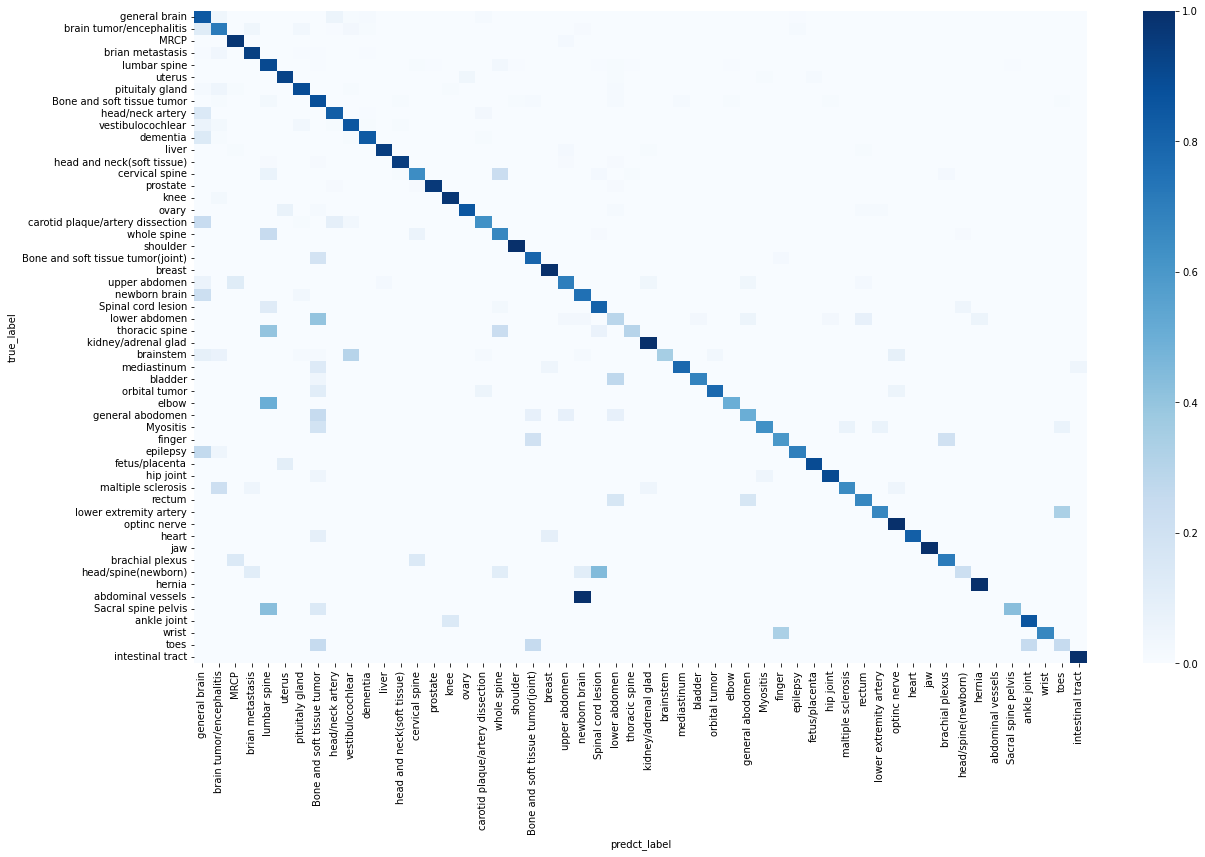

In [229]:
plt.figure(figsize=(20, 12))
sns.heatmap(confn, annot=False,cmap='Blues' ,fmt='d')
plt.xlabel("predct_label")
plt.ylabel('true_label')

plt.savefig('nn_sB_heatmap.png')

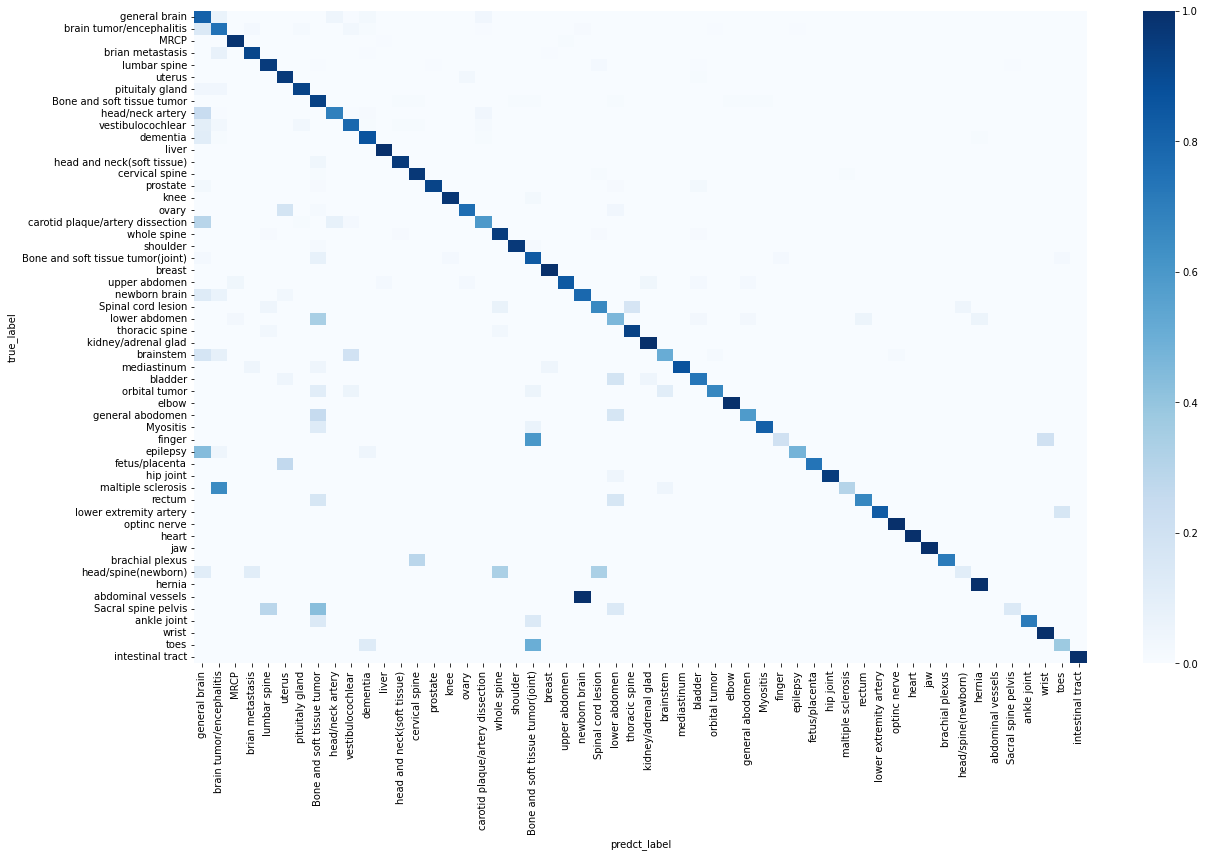

In [228]:
plt.figure(figsize=(20, 12))
sns.heatmap(confl, annot=False,cmap='Blues',fmt='d')
plt.xlabel("predct_label")
plt.ylabel('true_label')

plt.savefig('lg_sB_heatmap.png')